# LightGBM Flight Delay Training

This notebook trains LightGBM Regressors using the LGBMRegr_pipeline
We'll focus on training the LightGBMRegressor Regression (Gamma, Tweedie, and maybe some other objectives like L1).

In [ ]:
# install packages if needed; colab has all of these though
# !pip install lightgbm joblib pandas numpy scikit-learn

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
import sys
import importlib
from google.colab import drive
from pprint import pprint

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Add project path
project_path = '/content/drive/My Drive/CIS 5200 Final Project/code'
if project_path not in sys.path:
    sys.path.append(project_path)

import LGBMRegr_pipeline
importlib.reload(LGBMRegr_pipeline)

from LGBMRegr_pipeline import (
    train_regressor,
    get_regressor_pipeline,
    InferencePipeline         # Wrapper for saving
)

print("Successfully loaded LightGBM Regressor Pipeline!")

Mounted at /content/drive
Successfully loaded LightGBM Regressor Pipeline!


# Set Paths

In [3]:
# configure paths (dataset paths, model and result paths for saving)

mod = "added_delay_20251202_034422" # or "1", "2" etc. for the smaller datasets
DATA_FILE_PATH = "/content/drive/My Drive/CIS 5200 Final Project/train_test_datasets/"

X_train_path = DATA_FILE_PATH + f'X_train_{mod}.csv'
y_train_path = DATA_FILE_PATH + f'y_train_{mod}.csv'
X_test_path = DATA_FILE_PATH + f'X_test_{mod}.csv'
y_test_path = DATA_FILE_PATH + f'y_test_{mod}.csv'


# Set Save Path
CHECKPOINT_DIR = "/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Gamma Regression"

# configure target variables
REGR_TARGET = 'DEP_ADDED_DELAY'

## Hyperparameter Tuning - Optuna

In [4]:
!pip install optuna
!pip install optuna-integration[wandb]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.0 MB/s eta 0:00:00


In [5]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import json
from sklearn.model_selection import train_test_split
import wandb

def objective(trial, X_train, y_train, X_valid, y_valid, objective_param, eval_metric, metric_func, metric_params={}):
    """
    Optuna objective with flexible metric parameters.
    """

    # Search Space
    params = {
        'objective': objective_param,
        'metric': eval_metric,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 7500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    # 3. Model
    model = lgb.LGBMRegressor(**params)

    # 4. Fit
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, eval_metric)
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0),
        pruning_callback
    ]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=eval_metric,
        callbacks=callbacks
    )

    # 5. Predict
    preds = model.predict(X_valid)
    preds = np.maximum(preds, 1e-9) # Safety for Gamma/Tweedie

    # 6. Flexible Scoring
    # This unpacks the dictionary: func(y, p, power=1.5)
    score = metric_func(y_valid, preds, **metric_params)

    return score

def run_optuna_tuning(
    X, y,
    objective_param, eval_metric,
    metric_func,
    metric_params=None, # Dictionary for extra metric args (e.g. {'power': 1.5})
    direction='minimize',
    n_trials=100,
    valid_size=0.2,
    study_name='lgbm_regression_flexible',
    wandb_project='flight_delay_project',
    save_dir='./',
    random_state=42
):

    if metric_params is None:
        metric_params = {}

    # 0. Categoricals
    if hasattr(X, 'select_dtypes'):
        object_cols = X.select_dtypes(include=['object']).columns
        if len(object_cols) > 0:
            X = X.copy()
            for col in object_cols:
                X[col] = X[col].astype('category')

    # 1. Split
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=valid_size, random_state=random_state
    )

    # 2. W&B
    # We log the custom metric params so you know what 'value' actually means
    wandb_config = {"metric_params": metric_params}
    wandbc = WeightsAndBiasesCallback(metric_name="value", wandb_kwargs={"project": wandb_project, "config": wandb_config})

    # 3. Study
    study = optuna.create_study(
        direction=direction,
        study_name=study_name,
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10, n_startup_trials=5)
    )

    print(f"Starting Optimization for {metric_func.__name__}...")
    print(f"Metric Params: {metric_params}")

    try:
        study.optimize(
            lambda trial: objective(
                trial,
                X_train, y_train,
                X_valid, y_valid,
                objective_param, eval_metric,
                metric_func,
                metric_params # Pass it down
            ),
            n_trials=n_trials,
            callbacks=[wandbc]
        )
    except KeyboardInterrupt:
        print("Interrupted! Saving current results...")

    # 4. Results
    print(f"\nBest Value: {study.best_value}")
    print("Best Params:", study.best_params)

    save_path = os.path.join(save_dir, f"best_params_{study_name}.json")
    with open(save_path, 'w') as f:
        json.dump(study.best_params, f, indent=4)

    return study

In [6]:
# 2. Prepare Data
# Load your dataset (assuming you have your X_train and y_train ready)
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)[REGR_TARGET]

# for HURDLE regressors
print('SELECTING ONLY POSITIVE EXAMPLES')
mask_pos = y_train > 0
X_train = X_train[mask_pos]
y_train = y_train[mask_pos]


# X_tune, _, y_tune, _ = train_test_split(
#     X_train,
#     y_train,
#     train_size=100000,  # Or use a float like 0.1 for 10%
# )

SELECTING ONLY POSITIVE EXAMPLES


In [ ]:
# how many examples left in y_train? ~17.2% of ~5 million, so ~860,000?
y_train.value_counts().sum()

np.int64(877028)

### Stratify the train sets for hyper parameter tuning

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def stratify_continuous_target(y, n_bins=10):
    """
    Creates discrete bins for stratifying a continuous, zero-inflated target.

    Bin 0: Exact Zeros (The 82% mass)
    Bin 1-10: Deciles of the positive values (The Gamma tail)
    """
    # 1. Initialize all as Bin 0 (Zeros)
    bins = np.zeros_like(y, dtype=int)

    # 2. Identify Positive Examples
    mask_pos = y > 0
    y_pos = y[mask_pos]

    if len(y_pos) > 0:
        # 3. Bin the positive tail into quantiles (e.g., deciles)
        # We add 1 so these bins start at 1, keeping 0 for the zeros
        try:
            # duplicates='drop' handles cases where multiple deciles might have the same value (rare in continuous)
            pos_bins = pd.qcut(y_pos, q=n_bins, labels=False, duplicates='drop') + 1
            bins[mask_pos] = pos_bins
        except ValueError:
            # Fallback if there are too few unique positive values to bin
            bins[mask_pos] = 1

    return bins

# --- USAGE EXAMPLE ---

# 1. Generate the bins based on your FULL target array
# (Assuming 'y' is your pandas Series or numpy array of DEP_ADDED_DELAY)
stratify_bins = stratify_continuous_target(y_train, n_bins=10)

# Check the balance (Optional)
print("Bin Counts for Stratification:")
print(pd.Series(stratify_bins).value_counts().sort_index())

# 2. Perform the Split
# Note: We pass 'stratify_bins' to the stratify parameter, NOT y itself.
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=100000,
    stratify=stratify_bins
)



Bin Counts for Stratification:
1     91289
2     99995
3     81865
4     85344
5     82063
6     86396
7     90433
8     88760
9     84253
10    86630
Name: count, dtype: int64

Original Zero Rate: 0.00%
Train Zero Rate:    0.00%


In [10]:
print(f"\nOriginal Zero Rate: {(y_train == 1).mean():.2%}")
print(f"Train Zero Rate:    {(y_tune == 1).mean():.2%}")


Original Zero Rate: 3.72%
Train Zero Rate:    3.77%


### Run Study

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_gamma_deviance, mean_tweedie_deviance
# 1. Login to W&B (Required)
wandb.login()

# 3. Run the Tuning
# - Log everything to W&B
# - Save
# gamma regression/hurdle
study = run_optuna_tuning(
    X_tune, y_tune,
    objective_param='gamma', eval_metric='gamma',
    metric_func=mean_gamma_deviance,
    metric_params={}, # Empty dict
    n_trials=50,
    direction='minimize',
    study_name='LightGBMRegrHurdle Gamma Study Dec6',
    wandb_project='CIS_5200_Final_Project',
    save_dir=CHECKPOINT_DIR
)

# Tweedie Single Stage
# study = run_optuna_tuning(
#     X_tune, y_tune,
#     objective_param='tweedie', eval_metric='tweedie',
#     metric_func=mean_gamma_deviance,
#     metric_params={}, # Empty dict
#     n_trials=50,
#     direction='minimize',
#     study_name='LightGBMRegrSingleStage Tweedie Study Dec6',
#     wandb_project='CIS_5200_Final_Project',
#     save_dir=CHECKPOINT_DIR
# )

# 4. Access Results Programmatically
print("Best params found:", study.best_params)
print("Best score:", study.best_value)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/tmp/ipython-input-1831115211.py:92: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="value", wandb_kwargs={"project": wandb_project, "config": wandb_config})


[I 2025-12-06 23:27:56,952] A new study created in memory with name: LightGBMRegrHurdle Gamma Study Dec6


Starting Optimization for mean_gamma_deviance...
Metric Params: {}


[I 2025-12-06 23:28:03,059] Trial 0 finished with value: 0.5410447919085913 and parameters: {'n_estimators': 7100, 'learning_rate': 0.27, 'num_leaves': 201, 'max_depth': 4, 'min_child_samples': 63, 'subsample': 0.8500000000000001, 'subsample_freq': 5, 'colsample_bytree': 1.0, 'reg_alpha': 1.5043429341936982e-08, 'reg_lambda': 8.21510924809206e-05}. Best is trial 0 with value: 0.5410447919085913.
[I 2025-12-06 23:28:12,868] Trial 1 finished with value: 0.7614948275094795 and parameters: {'n_estimators': 4000, 'learning_rate': 0.18000000000000002, 'num_leaves': 95, 'max_depth': 3, 'min_child_samples': 41, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.95, 'reg_alpha': 5.6328194638728456e-08, 'reg_lambda': 3.3585854328242724e-08}. Best is trial 0 with value: 0.5410447919085913.
[I 2025-12-06 23:28:34,263] Trial 2 finished with value: 0.5435430193127376 and parameters: {'n_estimators': 500, 'learning_rate': 0.09999999999999999, 'num_leaves': 240, 'max_depth': 8, 'min_child_sa


Best Value: 0.48376578276245846
Best Params: {'n_estimators': 400, 'learning_rate': 0.09999999999999999, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 1.0, 'subsample_freq': 6, 'colsample_bytree': 1.0, 'reg_alpha': 0.3722531180177258, 'reg_lambda': 0.0006143855578054196}
Best params found: {'n_estimators': 400, 'learning_rate': 0.09999999999999999, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 1.0, 'subsample_freq': 6, 'colsample_bytree': 1.0, 'reg_alpha': 0.3722531180177258, 'reg_lambda': 0.0006143855578054196}
Best score: 0.48376578276245846


## SKLearn RandomizedSearch approach - Not used for Final Hyperparameter sweep, code is outdated

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_tweedie_deviance, make_scorer

# Load Subset for Tuning
X_tune = pd.read_csv(X_train_path, nrows=100000)
y_tune = pd.read_csv(y_train_path, nrows=100000)[REGR_TARGET]

# Build Tuning Pipeline
# Note: We use the sklearn API wrapper for this part
prep_pipeline = get_lgbm_pipeline()
lgbm_estimator = lgb.LGBMRegressor(
    objective='tweedie',
    tweedie_variance_power=1.5,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
# lgbm_estimator = lgb.LGBMRegressor(random_state=42, verbose=-1)

full_tune_pipeline = Pipeline(steps=[
    ('prep', prep_pipeline),
    ('model', lgbm_estimator)
])

# Define LightGBM Parameter Grid
param_dist = {
    'model__n_estimators': [100, 200, 300, 500, 750, 1000], # Controls num trees
    'model__num_leaves': [31, 50, 70, 100],      # Controls complexity (crucial for LGBM)
    'model__learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],   # Lower is better but slower
    'model__subsample': [0.6, 0.8, 1.0],         # Bagging fraction
    'model__colsample_bytree': [0.6, 0.8, 1.0],  # Feature fraction
    'model__min_child_samples': [20, 50, 100],   # Min data in leaf to prevent overfitting
}

# Define scorers to use:
# https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
# regression
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-adapt-metric
tweedie_scorer = make_scorer(mean_tweedie_deviance, power=1.5, greater_is_better=False)
scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE': 'neg_mean_absolute_error',
           'Mean Tweedie Deviance': tweedie_scorer}
refit = 'Mean Tweedie Deviance'

# classification
# scoring = {'AUC': 'roc_auc', 'F1 Score': 'f1', 'Precision': 'precision', 'Recall': 'recall'}
# refit = 'AUC'

# Define search
search = RandomizedSearchCV(
    estimator=full_tune_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring=scoring,
    refit=refit,
    n_jobs=1,
    verbose=3
)

print("Starting Hyperparameter Search...")
search.fit(X_tune, y_tune)
results = search.cv_results_

KeyboardInterrupt: 

### Save hyperparam results

In [ ]:
# save dictionary with timestamp in name for safe saving

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = CHECKPOINT_DIR + f"lgbm_regr_hyperparam_sweep_results_{timestamp}.pkl"

with open(results_path, 'wb') as f:
    pickle.dump(results, f)


In [ ]:
# load results from pickle file
with open(CHECKPOINT_DIR + 'lgbm_regr_hyperparam_sweep_results_20251130_015014.pkl', 'rb') as f:
    results = pickle.load(f)
results

{'mean_fit_time': array([10.01286268,  4.61024356,  7.65443699,  1.84813921,  4.7338829 ,
         6.90420572, 10.8323102 ,  4.65101663,  2.74448538, 14.05534005,
         4.23976636, 17.07408977,  9.73846459,  6.31931297, 18.53678354]),
 'std_fit_time': array([1.93440066, 1.85016044, 1.2706116 , 0.04142529, 1.35024882,
        1.60156945, 0.10699573, 1.04359763, 0.78772761, 0.70044601,
        1.35702393, 1.26363259, 1.25458433, 1.31167457, 5.1542156 ]),
 'mean_score_time': array([3.38158647, 0.81792005, 1.57821751, 0.35871474, 1.00734854,
        1.66527001, 3.02946568, 0.90051651, 0.56666406, 4.16758672,
        0.82999134, 5.73811165, 2.88532813, 0.91393018, 4.3222177 ]),
 'std_score_time': array([0.70087234, 0.08660786, 0.02749004, 0.00245804, 0.26932014,
        0.4982522 , 0.04669569, 0.12330365, 0.16512871, 0.70624776,
        0.06272801, 0.83634718, 0.21003973, 0.01276489, 1.41109876]),
 'param_model__subsample': masked_array(data=[0.8, 1.0, 0.6, 0.8, 0.8, 0.8, 0.6, 0.8, 1.0, 

In [ ]:
# get best params by Tweedie
tweedie_best_params = results['params'][np.argmin(results['rank_test_Mean Tweedie Deviance'])]
tweedie_best_score = results['mean_test_Mean Tweedie Deviance'][np.argmin(results['rank_test_Mean Tweedie Deviance'])]
print(f"Best Params (by Tweedie): {tweedie_best_params}")
print(f"Best Mean Tweedie Deviance (Validation): {-tweedie_best_score}")

# get best params by RMSE
rmse_best_params = results['params'][np.argmin(results['rank_test_RMSE'])]
rmse_best_score = results['mean_test_RMSE'][np.argmin(results['rank_test_RMSE'])]
print(f"Best Params (by RMSE): {rmse_best_params}")
print(f"Best RMSE (Validation): {-rmse_best_score}")

# get best params by MAE
mae_best_params = results['params'][np.argmin(results['rank_test_MAE'])]
mae_best_score = results['mean_test_MAE'][np.argmin(results['rank_test_MAE'])]
print(f"Best Params (by MAE) {mae_best_params}")
print(f"Best MAE (Validation): {-mae_best_score}")

Best Params (by Tweedie): {'model__subsample': 0.8, 'model__num_leaves': 100, 'model__n_estimators': 200, 'model__min_child_samples': 100, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}
Best Mean Tweedie Deviance (Validation): 10.980465015041355
Best Params (by RMSE): {'model__subsample': 0.8, 'model__num_leaves': 50, 'model__n_estimators': 200, 'model__min_child_samples': 100, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}
Best RMSE (Validation): 20.053687257403205
Best Params (by MAE) {'model__subsample': 1.0, 'model__num_leaves': 100, 'model__n_estimators': 1000, 'model__min_child_samples': 20, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.6}
Best MAE (Validation): 9.35462235094625


## Train Regression Model (Tweedie or Gamma or somethign else)
Uses the custom training loop with **Early Stopping**.

In [16]:
# --- CONFIGURATION ---
pos_only = True


stopping_rounds = 100 # threshold for early stopping (train until you don't improve for <- 100 rounds )

model_params = {'objective': 'gamma', 'metric': ['gamma', 'mae', 'rmse', 'r2']}
# model_params = {'objective': 'regression_l1', 'metric': ['mae', 'rmse', 'r2']}
# model_params = {'objective': 'tweedie', 'tweedie_variance_power': 1.5, 'metric': ['tweedie']}
extra_metrics = {}
# best_gamma_hyperparams = {'n_estimators': 4900, 'learning_rate': 0.03, 'num_leaves': 150,
#                'max_depth': 13, 'min_child_samples': 80,
#                'subsample': 0.9, 'subsample_freq': 6, 'colsample_bytree': 0.7,
#                'reg_alpha': 2.0631737727940105e-06, 'reg_lambda': 0.00020147986163818538}
best_gamma_hyperparams_dec_6 = {'n_estimators': 2000, 'learning_rate': 0.09999999999999999,
                                'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 36,
                                'subsample': 1.0,
                                'subsample_freq': 6, 'colsample_bytree': 1.0,
                                'reg_alpha': 0.3722531180177258, 'reg_lambda': 0.0006143855578054196}
best_gamma_hyperparams_dec_6.update(model_params)
# best_tweedie_hyperparams = {'n_estimators': 4900, 'learning_rate': 0.03, 'num_leaves': 150,
#                'max_depth': 15, 'min_child_samples': 80,
#                'subsample': 0.75, 'subsample_freq': 6, 'colsample_bytree': 0.7,
#                'reg_alpha': 2.0631737727940105e-06, 'reg_lambda': 0.00020147986163818538}

# best_tweedie_hyperparams.update(model_params)
# Train


results_reg = train_regressor(
    X_train_path=X_train_path,
    y_train_path=y_train_path,
    X_test_path=X_test_path,
    y_test_path=y_test_path,
    description=f"LGBM_RegHurdle_GammaDec6_added_delay",
    stopping_rounds=stopping_rounds,
    checkpoint_dir=CHECKPOINT_DIR,
    pos_only=pos_only,
    **best_gamma_hyperparams_dec_6
)

pprint(results_reg)


--- Starting Regressor Training: LGBM_RegHurdle_GammaDec6_added_delay ---
  Loading Training Data...
  Filtering for positive delays... (Original: 5086383)
  Training samples remaining: 877028
  Creating Validation Split (15%)...
This model objective is: gamma
  Preprocessing & Fitting...


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Early Stopping: 100 rounds
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11413
[LightGBM] [Info] Number of data points in the train set: 745473, number of used features: 48
[LightGBM] [Info] Start training from score 3.456220
Training until validation scores don't improve for 100 rounds
[100]	valid's gamma: 4.1339	valid's l1: 10.5294	valid's rmse: 13.9704
[200]	valid's gamma: 4.12048	valid's l1: 9.61698	valid's rmse: 12.7844
[300]	valid's gamma: 4.11322	valid's l1: 9.17745	valid's rmse: 12.278
[400]	valid's gamma: 4.10857	valid's l1: 8.90714	valid's rmse

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  RMSE:  11.3616
  MAE:   8.0759
  MAPE:  74.3285%
  Metrics saved to: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_GammaDec6_added_delay_20251207_000432_metrics.json
{'checkpoint_path': '/content/drive/My Drive/CIS 5200 Final '
                    'Project/models/lightGBM/Gamma '
                    'Regression/LGBM_RegHurdle_GammaDec6_added_delay_20251207_000432.joblib',
 'description': 'LGBM_RegHurdle_GammaDec6_added_delay',
 'gamma_deviance': 0.3366776616691882,
 'mae': 8.075917705575664,
 'mape': 0.7432847916822478,
 'parameters': {'boosting_type': 'gbdt',
                'class_weight': None,
                'colsample_bytree': 1.0,
                'importance_type': 'split',
                'learning_rate': 0.09999999999999999,
                'max_depth': 10,
                'metric': ['gamma', 'mae', 'rmse', 'r2'],
                'min_child_samples': 36,
                'min_child_weight': 0.001,
                'min_split_gai

## 6. Inference from Checkpoint
How to load a saved model later.

In [15]:
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Load
# chk_path = CHECKPOINT_DIR + 'LGBM_Reg_SingleStage_Tweedie_added_delay_20251204_074723.joblib'
chk_path = '/content/drive/MyDrive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_Gamma_added_delay_20251203_041357.joblib'
chk_path = results_reg['checkpoint_path'] # Or paste a string path
print(f"Loading: {chk_path}")
loaded_pipeline = joblib.load(chk_path)
model = loaded_pipeline.model
feature_names = model.feature_name_
importances = model.feature_importances_

Loading: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_GammaDec6_added_delay_20251206_233908.joblib


In [ ]:
# load model performance metrics from json file
import json
results_path = '/content/drive/MyDrive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_Gamma_added_delay_20251203_041357_metrics.json'
results_path = '/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Tweedie Regression/LGBM_Reg_SingleStage_Tweedie_added_delay_20251204_074723_metrics.json'

# results_path = results_reg['metrics_path']
with open(results_path, 'r') as f:
    results = json.load(f)
pprint(results)

{'checkpoint_path': '/content/drive/My Drive/CIS 5200 Final '
                    'Project/models/lightGBM/Tweedie '
                    'Regression/LGBM_Reg_SingleStage_Tweedie_added_delay_20251204_074723.joblib',
 'description': 'LGBM_Reg_SingleStage_Tweedie_added_delay',
 'mae': 2.4297521120627334,
 'mape': 1968743541721001.0,
 'parameters': {'boosting_type': 'gbdt',
                'class_weight': None,
                'colsample_bytree': 0.7,
                'importance_type': 'split',
                'learning_rate': 0.03,
                'max_depth': 15,
                'metric': ['tweedie'],
                'min_child_samples': 80,
                'min_child_weight': 0.001,
                'min_split_gain': 0.0,
                'n_estimators': 4900,
                'n_jobs': -1,
                'num_leaves': 150,
                'objective': 'tweedie',
                'random_state': None,
                'reg_alpha': 2.0631737727940105e-06,
                'reg_lambda': 0.0002

Top 10 Features:
                Feature  Importance
21           ROUTE_NAME       24280
22       INCOMING_ROUTE       18529
2              DEP_TIME       13110
23      CARRIER_AIRPORT       12165
3          DEP_TIME_BLK        8809
20  DESTINATION_AIRPORT        6214
19     PREVIOUS_AIRPORT        5159
5              DEP_HOUR        2722
0                 MONTH        2240
18    DEPARTING_AIRPORT        1942


/tmp/ipython-input-3805232326.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance.head(20), palette='viridis')


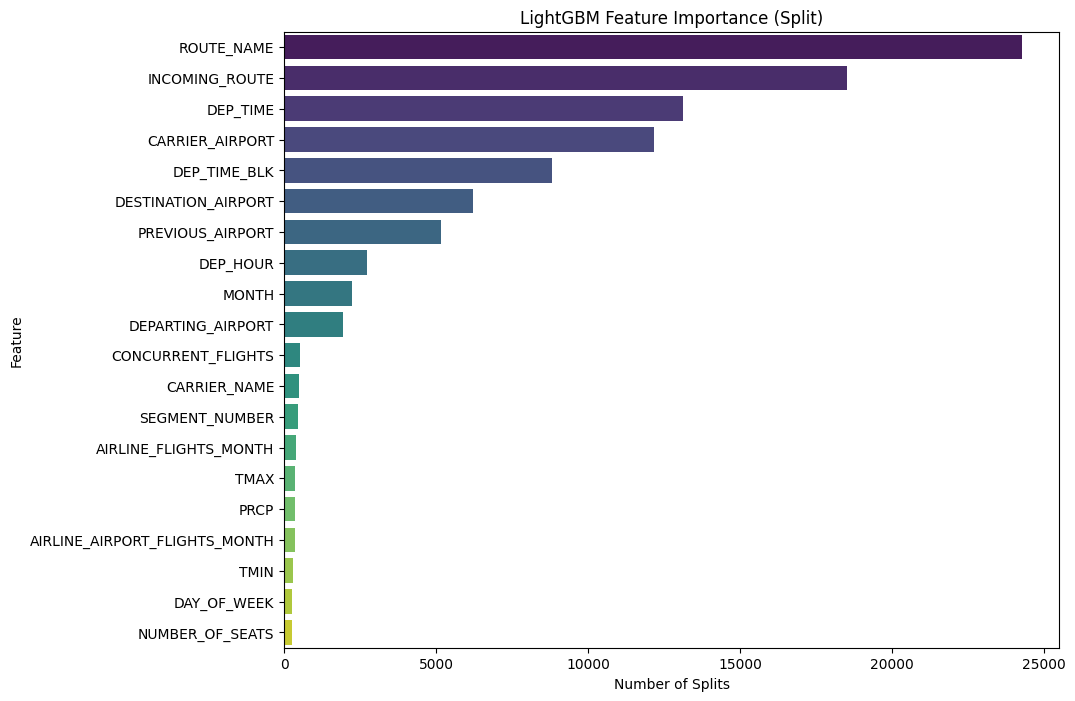

In [ ]:
# 3. Create a DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Print the Top 10 specific numbers you were seeing
print("Top 10 Features:")
print(df_importance.head(10))

# 5. Plot Top 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance.head(20), palette='viridis')
plt.title('LightGBM Feature Importance (Split)')
plt.xlabel('Number of Splits')
plt.show()